In [1]:
from util import getData, getBinaryData, y2indicator, error_rate, init_weight_and_bias
from sklearn.utils import shuffle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

C:\Users\Denis\AppData\Local\conda\conda\envs\tensorflow_env_gpu\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [17]:
class HiddenLayer(object):
    def __init__(self, M1, M2, an_id):
        self.id = an_id
        self.M1 = M1
        self.M2 = M2
        W, b = init_weight_and_bias(M1, M2)
        self.W = tf.Variable(W.astype(np.float32))
        self.b = tf.Variable(b.astype(np.float32))
        self.params = [self.W, self.b]
        
    def forward(self, X):
        return tf.nn.relu(tf.matmul(X, self.W) + self.b)
    
class ANN(object):
    def __init__(self, hidden_layer_sizes):
        self.hidden_layer_sizes = hidden_layer_sizes
        
    def fit(self, X, Y, learning_rate=10e-7, mu=0.99, decay=0.999, reg=10e-3,
           epochs=400, batch_sz=100, show_fig=False):
        K = len(set(Y))
        
        #make a validation set
        X, Y = shuffle(X, Y)
        X = X.astype(np.float32)
        Y = y2indicator(Y).astype(np.float32)
        Xvalid, Yvalid = X[-1000:], Y[-1000:]
        Yvalid_flat = np.argmax(Yvalid, axis=1)
        X, Y = X[:-1000], Y[:-1000]
        
        #initialize hidden layers
        N, D = X.shape
        self.hidden_layers = []
        M1 = D
        count = 0
        for M2 in self.hidden_layer_sizes:
            h = HiddenLayer(M1, M2, count)
            self.hidden_layers.append(h)
            M1 = M2
            count += 1
        W, b = init_weight_and_bias(M1, K)
        self.W = tf.Variable(W.astype(np.float32))
        self.b = tf.Variable(b.astype(np.float32))
        
        # collect params
        self.params = [self.W, self.b]
        for h in self.hidden_layers:
            self.params += h.params
            
        tfX = tf.placeholder(tf.float32, shape=(None, D), name='X')
        tfT = tf.placeholder(tf.float32, shape=(None, K), name='T')
        act = self.forward(tfX)
        
        rcost = reg*sum([tf.nn.l2_loss(p) for p in self.params]) #regularization cost
        cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=act, labels=tfT)) + rcost
        prediction = self.predict(tfX)
        train_op = tf.train.RMSPropOptimizer(learning_rate, decay=decay, momentum=mu).minimize(cost)
        
        n_batches = N // batch_sz
        costs = []
        init = tf.global_variables_initializer()
        with tf.Session() as session:
            session.run(init)
            for i in range(epochs):
                X, Y = shuffle(X, Y)
                for j in range(n_batches):
                    Xbatch = X[j*batch_sz:(j*batch_sz + batch_sz)]
                    Ybatch = Y[j*batch_sz:(j*batch_sz + batch_sz)]
                    
                    session.run(train_op, feed_dict={tfX: Xbatch, tfT: Ybatch})
                    
                    if j % 20 == 0:
                        c = session.run(cost, feed_dict={tfX: Xvalid, tfT: Yvalid})
                        costs.append(c)
                        
                        p = session.run(prediction, feed_dict={tfX: Xvalid, tfT: Yvalid})
                        e = error_rate(Yvalid_flat, p)
                print("i:", i, "j:", j, "nb:", n_batches, "cost:", c, "error_rate:", e)
                        
        if show_fig:
            plt.plot(costs)
            plt.show()
            
    def forward(self, X):
        Z = X
        for h in self.hidden_layers:
            Z = h.forward(Z)
        return tf.matmul(Z, self.W) + self.b
    
    def predict(self, X):
        act = self.forward(X)
        return tf.argmax(act, 1)

In [7]:
import pandas as pd
df = pd.read_csv('c:/Users/Denis/Desktop/fer2013/fer2013.csv')
df

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
5,2,55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...,Training
6,4,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...,Training
7,3,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...,Training
8,3,85 84 90 121 101 102 133 153 153 169 177 189 1...,Training
9,2,255 254 255 254 254 179 122 107 95 124 149 150...,Training


In [4]:
X = []
for i in df.iloc[:, 1]:
    X.append(i.split(' '))
X = np.array(X, dtype=np.float32)
Y = df.iloc[:, 0]

i: 0 j: 347 nb: 348 cost: 12.864573 error_rate: 0.837
i: 1 j: 347 nb: 348 cost: 12.44277 error_rate: 0.806
i: 2 j: 347 nb: 348 cost: 12.3983 error_rate: 0.791
i: 3 j: 347 nb: 348 cost: 12.317645 error_rate: 0.821
i: 4 j: 347 nb: 348 cost: 12.2943535 error_rate: 0.83
i: 5 j: 347 nb: 348 cost: 12.293301 error_rate: 0.817
i: 6 j: 347 nb: 348 cost: 12.238659 error_rate: 0.806
i: 7 j: 347 nb: 348 cost: 12.213974 error_rate: 0.809
i: 8 j: 347 nb: 348 cost: 12.190495 error_rate: 0.815
i: 9 j: 347 nb: 348 cost: 12.101008 error_rate: 0.802
i: 10 j: 347 nb: 348 cost: 12.058794 error_rate: 0.794
i: 11 j: 347 nb: 348 cost: 12.064694 error_rate: 0.804
i: 12 j: 347 nb: 348 cost: 11.961514 error_rate: 0.796
i: 13 j: 347 nb: 348 cost: 11.876508 error_rate: 0.808
i: 14 j: 347 nb: 348 cost: 11.805228 error_rate: 0.815
i: 15 j: 347 nb: 348 cost: 11.7499695 error_rate: 0.796
i: 16 j: 347 nb: 348 cost: 11.593809 error_rate: 0.797
i: 17 j: 347 nb: 348 cost: 11.4523115 error_rate: 0.81
i: 18 j: 347 nb: 348 c

i: 151 j: 347 nb: 348 cost: 1.8341395 error_rate: 0.78
i: 152 j: 347 nb: 348 cost: 1.8380272 error_rate: 0.78
i: 153 j: 347 nb: 348 cost: 1.8341323 error_rate: 0.78
i: 154 j: 347 nb: 348 cost: 1.8376483 error_rate: 0.78
i: 155 j: 347 nb: 348 cost: 1.8359082 error_rate: 0.78
i: 156 j: 347 nb: 348 cost: 1.8406163 error_rate: 0.78
i: 157 j: 347 nb: 348 cost: 1.8413316 error_rate: 0.78
i: 158 j: 347 nb: 348 cost: 1.837612 error_rate: 0.78
i: 159 j: 347 nb: 348 cost: 1.8346695 error_rate: 0.78
i: 160 j: 347 nb: 348 cost: 1.834041 error_rate: 0.78
i: 161 j: 347 nb: 348 cost: 1.8365517 error_rate: 0.78
i: 162 j: 347 nb: 348 cost: 1.8366183 error_rate: 0.78
i: 163 j: 347 nb: 348 cost: 1.8339884 error_rate: 0.78
i: 164 j: 347 nb: 348 cost: 1.8375964 error_rate: 0.78
i: 165 j: 347 nb: 348 cost: 1.8337529 error_rate: 0.78
i: 166 j: 347 nb: 348 cost: 1.832432 error_rate: 0.78
i: 167 j: 347 nb: 348 cost: 1.8321741 error_rate: 0.78
i: 168 j: 347 nb: 348 cost: 1.8354601 error_rate: 0.78
i: 169 j: 347

i: 301 j: 347 nb: 348 cost: 1.8378541 error_rate: 0.78
i: 302 j: 347 nb: 348 cost: 1.8350276 error_rate: 0.78
i: 303 j: 347 nb: 348 cost: 1.8400712 error_rate: 0.78
i: 304 j: 347 nb: 348 cost: 1.8332812 error_rate: 0.78
i: 305 j: 347 nb: 348 cost: 1.8397777 error_rate: 0.78
i: 306 j: 347 nb: 348 cost: 1.8637946 error_rate: 0.78
i: 307 j: 347 nb: 348 cost: 1.8464848 error_rate: 0.78
i: 308 j: 347 nb: 348 cost: 1.8443048 error_rate: 0.78
i: 309 j: 347 nb: 348 cost: 1.8435733 error_rate: 0.78
i: 310 j: 347 nb: 348 cost: 1.8367893 error_rate: 0.78
i: 311 j: 347 nb: 348 cost: 1.8384717 error_rate: 0.78
i: 312 j: 347 nb: 348 cost: 1.8362802 error_rate: 0.78
i: 313 j: 347 nb: 348 cost: 1.8337195 error_rate: 0.78
i: 314 j: 347 nb: 348 cost: 1.8341062 error_rate: 0.78
i: 315 j: 347 nb: 348 cost: 1.8330044 error_rate: 0.78
i: 316 j: 347 nb: 348 cost: 1.8378125 error_rate: 0.78
i: 317 j: 347 nb: 348 cost: 1.8353584 error_rate: 0.78
i: 318 j: 347 nb: 348 cost: 1.8367152 error_rate: 0.78
i: 319 j: 

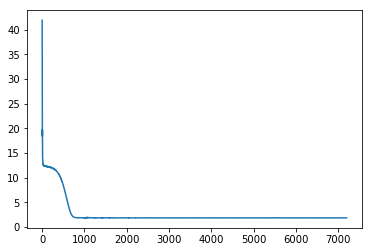

In [18]:
model = ANN([2000, 1000, 500])
model.fit(X, Y, show_fig=True)

In [20]:
from sklearn.metrics import accuracy_score

accuracy_score(Y[:-500], model.predict(X[:-500]))

TypeError: Input 'b' of 'MatMul' Op has type float32 that does not match type float64 of argument 'a'.

In [25]:
model.predict(X[-1].astype(np.float32))

ValueError: Shape must be rank 2 but is rank 1 for 'MatMul_51' (op: 'MatMul') with input shapes: [2304], [2304,2000].

In [27]:
len(X[-1].astype(np.float32))

2304